# Import Libraries

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from scipy.io import loadmat
from scipy import signal
from scipy.signal import butter, filtfilt, welch
import warnings
warnings.filterwarnings('ignore')
import os
import joblib
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import scale, MinMaxScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score
!pip install mne
from mne.decoding import CSP
import mne
from google.colab import drive
drive.mount('/content/drive')
data='drive/My Drive/Motor Imagery/data_set_IVa_ay.mat'

# Dataset Exploration

In [2]:
data=loadmat(data)

In [ ]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'mrk', 'nfo', 'cnt'])

In [ ]:
data['cnt'][0:3,0:10]

array([[1328,  598,  440,  587,  700,  534,  293,  173,  692,  181],
       [1430,  697,  558,  682,  792,  650,  435,  306,  795,  304],
       [1362,  633,  494,  618,  769,  558,  319,  245,  818,  207]],
      dtype=int16)

In [ ]:
data['cnt'].shape

(283562, 118)

In [ ]:
data['mrk']

array([[(array([[  6163,   6742,   7836,   8404,   8964,  10612,  11734,  12276,
                 12840,  13374,  13924,  14470,  15006,  15544,  16096,  16670,
                 18352,  21610,  22192,  22757,  24454,  25538,  26108,  26688,
                 27230,  27787,  28326,  29458,  30012,  30557,  32245,  32826,
                 33960,  35060,  37729,  38284,  38860,  39434,  39992,  40565,
                 42205,  43845,  44397,  44974,  45524,  46069,  46624,  47742,
                 48854,  49401,  49953,  54348,  55458,  56547,  57098,  57656,
                 58237,  58787,  59332,  59894,  60992,  62109,  62684,  63258,
                 66604,  67160,  67721,  68842,  69394,  69928,  76554,  77110,
                 77686,  78258,  78820,  79358,  81012,  81581,  82684,  83264,
                 83807,  84340,  84908,  85460,  86012,  87728,  88264,  89374,
                 92590,  93132,  93667,  94772,  95308,  97540,  98102,  99227,
                 99764, 100886, 101470,

# Data Preprocessing

In [3]:
cnt=0.1*data['cnt'].astype(np.float32)

In [ ]:
cnt[0]

array([ 132.8       ,   59.8       ,   44.        ,   58.7       ,
         70.        ,   53.4       ,   29.300001  ,   17.300001  ,
         69.200005  ,   18.1       ,   54.2       ,   16.        ,
         63.8       ,   32.8       ,   71.4       ,   52.5       ,
         50.        ,  -15.7       ,   46.9       ,   76.4       ,
         55.4       ,   68.        ,   86.8       ,   21.6       ,
         37.600002  ,   47.600002  ,   22.9       ,   19.7       ,
         22.9       ,    0.90000004,   67.1       ,   78.700005  ,
         92.3       ,   77.5       ,    4.1       ,   35.        ,
         74.4       ,   32.9       ,   44.4       ,   78.5       ,
        -21.800001  ,   44.7       ,  -21.800001  ,   60.7       ,
         10.6       ,   52.100002  ,   90.1       ,   84.8       ,
         30.5       ,   30.6       ,   49.3       ,   14.1       ,
        -19.800001  ,   10.1       ,   66.4       ,   63.9       ,
        108.9       ,   47.5       ,   69.4       ,   75.70000

In [4]:
fs = data['nfo']['fs'][0][0][0][0]

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass(data, lowcut=8, highcut=30, fs=100):
    b, a = butter_bandpass(lowcut, highcut, fs)
    return filtfilt(b, a, data, axis=0)

filtered_cnt = apply_bandpass(cnt, lowcut=8, highcut=30, fs=fs)

In [ ]:
filtered_cnt[0]

array([ 5.28264568e-02,  4.29943992e-02,  5.09508722e-02,  5.72471797e-02,
        4.03690886e-02,  4.73977500e-02,  3.59584726e-02,  4.66491131e-02,
        3.77921460e-02,  3.46151447e-02,  2.82026132e-02,  4.30676758e-02,
        3.61243979e-02,  5.00606456e-02,  2.77380694e-02,  2.53533157e-02,
        2.60824868e-02,  4.43565778e-02,  4.36002701e-02,  4.63369264e-02,
        3.99536298e-02, -8.83801895e-03,  4.58002994e-02,  2.21443291e-02,
        2.39181896e-02,  4.43685456e-02,  4.41705480e-02,  4.20037585e-02,
        3.41153214e-02,  1.83017220e-02,  6.23793699e-02,  5.32555796e-02,
        3.65750807e-02,  2.14351854e-02,  4.36418977e-02,  3.94311839e-02,
        3.33609593e-02,  3.17639134e-02,  3.13160875e-02,  2.86860472e-03,
        8.71678842e-02,  4.97894233e-02,  4.39703389e-02,  2.41026610e-02,
        7.86824451e-02,  3.76075029e-02,  4.49301324e-02,  3.48169060e-02,
        1.17998897e-02,  7.57587012e-02,  6.27696986e-02,  6.07817099e-02,
        5.65926489e-02,  

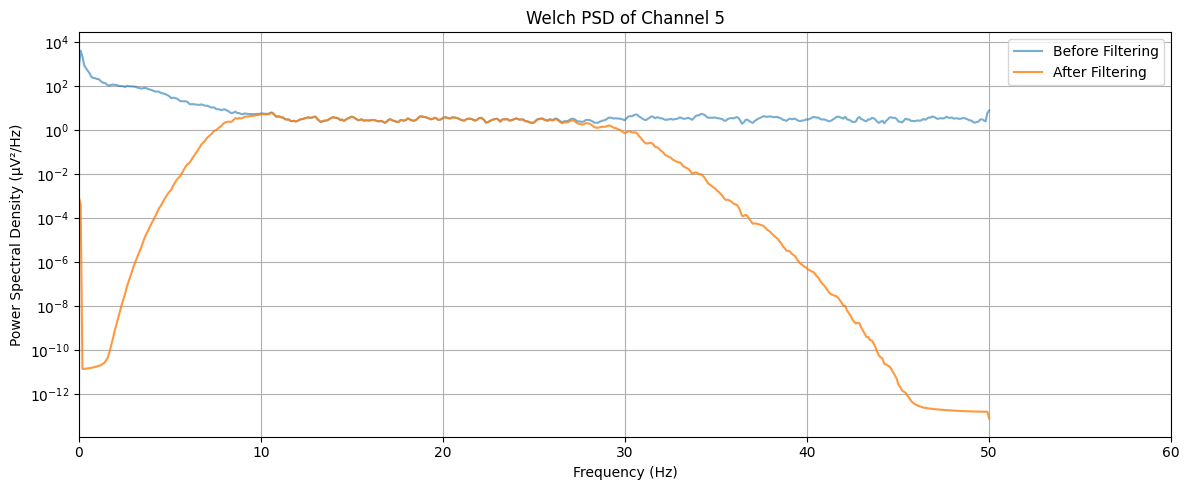

In [ ]:
channel_index = 5
raw_signal = cnt[:, channel_index]
filtered_signal = filtered_cnt[:, channel_index]

f_raw, psd_raw = welch(raw_signal, fs=fs, nperseg=1024)
f_filt, psd_filt = welch(filtered_signal, fs=fs, nperseg=1024)

plt.figure(figsize=(12, 5))
plt.semilogy(f_raw, psd_raw, label='Before Filtering', alpha=0.6)
plt.semilogy(f_filt, psd_filt, label='After Filtering', alpha=0.8)
plt.xlim(0, 60)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (µV²/Hz)")
plt.title(f"Welch PSD of Channel {channel_index}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


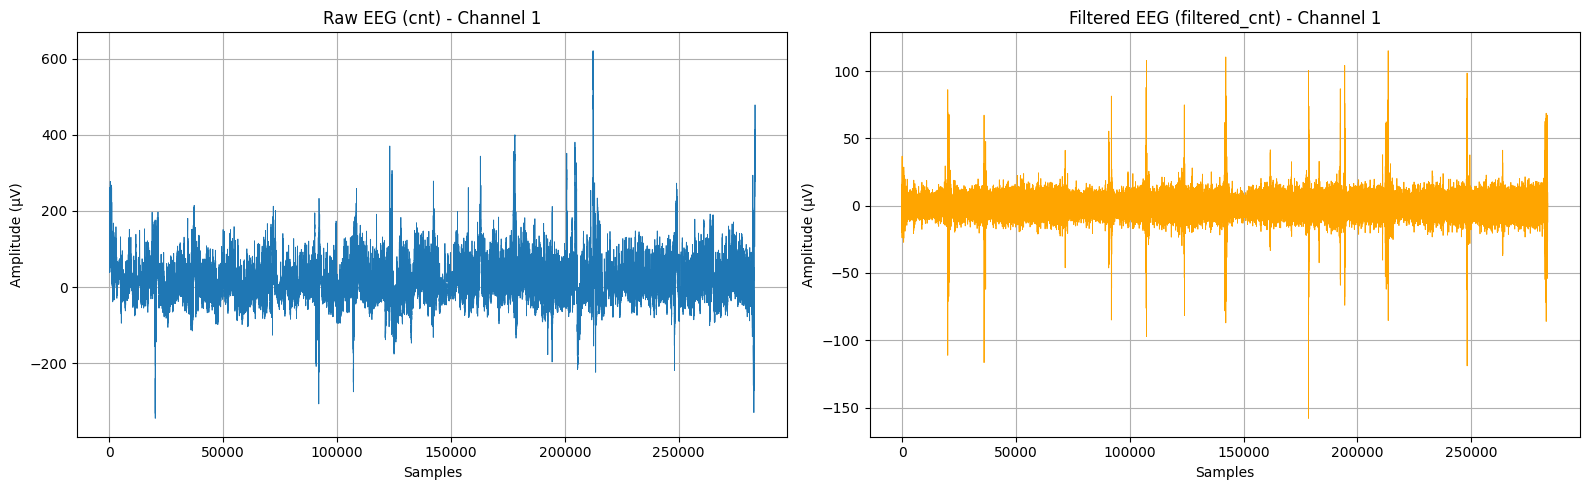

In [ ]:
channel = 1

plt.figure(figsize=(16, 5))

plt.subplot(1, 2, 1)
plt.plot(cnt[:, channel], linewidth=0.6)
plt.title(f"Raw EEG (cnt) - Channel {channel}")
plt.xlabel("Samples")
plt.ylabel("Amplitude (µV)")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(filtered_cnt[:, channel], linewidth=0.6, color='orange')
plt.title(f"Filtered EEG (filtered_cnt) - Channel {channel}")
plt.xlabel("Samples")
plt.ylabel("Amplitude (µV)")
plt.grid(True)

plt.tight_layout()
plt.show()



In [6]:
mrk = {
    'pos': data['mrk']['pos'][0][0].flatten(),
    'y': data['mrk']['y'][0][0].flatten()
}

In [7]:
mrk_y=mrk['y']
mrk_pos=mrk['pos']

In [8]:
y = mrk_y.flatten()

labeled_idx = np.where(~np.isnan(y))[0]

unlabeled_idx = np.where(np.isnan(y))[0]

print("Labeled trials:", len(labeled_idx))
print("Unlabeled trials:", len(unlabeled_idx))

pos_labeled = mrk_pos[labeled_idx]
pos_unlabeled = mrk_pos[unlabeled_idx]

y_labeled = y[labeled_idx].astype(int)


Labeled trials: 28
Unlabeled trials: 252


In [9]:
def create_epochs(cnt, positions, fs, tmin=0.58, tmax=2.1):
    samples_before = int(tmin * fs)
    samples_after  = int(tmax * fs)
    window_size    = samples_after - samples_before

    epochs = []
    for p in positions:
        start = p + samples_before
        stop  = p + samples_after
        epochs.append(cnt[start:stop])
    return np.array(epochs)


X_labeled = create_epochs(filtered_cnt, pos_labeled, fs)
X_unlabeled = create_epochs(filtered_cnt, pos_unlabeled, fs)

print(X_labeled.shape, y_labeled.shape)
print(X_unlabeled.shape)


(28, 153, 118) (28,)
(252, 153, 118)


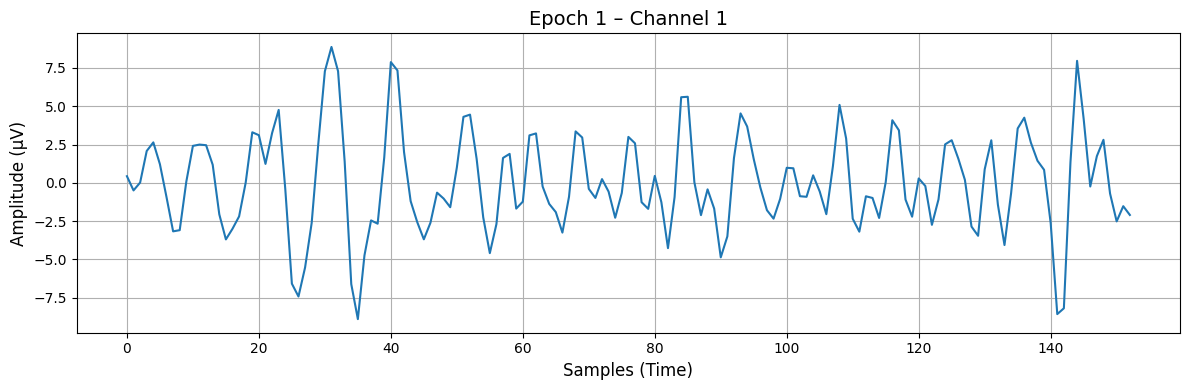

In [ ]:
epoch_idx = 0
channel_idx = 0

epoch = X_labeled[epoch_idx]

plt.figure(figsize=(12, 4))
plt.plot(epoch[:, channel_idx])

plt.title(f"Epoch {epoch_idx+1} – Channel {channel_idx+1}", fontsize=14)
plt.xlabel("Samples (Time)", fontsize=12)
plt.ylabel("Amplitude (µV)", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
clab_raw = data['nfo']['clab'][0][0]
if clab_raw.shape[0] == 1:
    clab_raw = clab_raw[0]
clab = [str(ch[0]) for ch in clab_raw]


PSD ANALYSIS - RIGHT HAND VS FOOT
Selected channel: Fp1 (index: 0)

Data shape: (28, 153, 118)
Right hand epochs: (18, 153, 118)
Foot epochs: (10, 153, 118)

Computing PSD for channel Fp1...


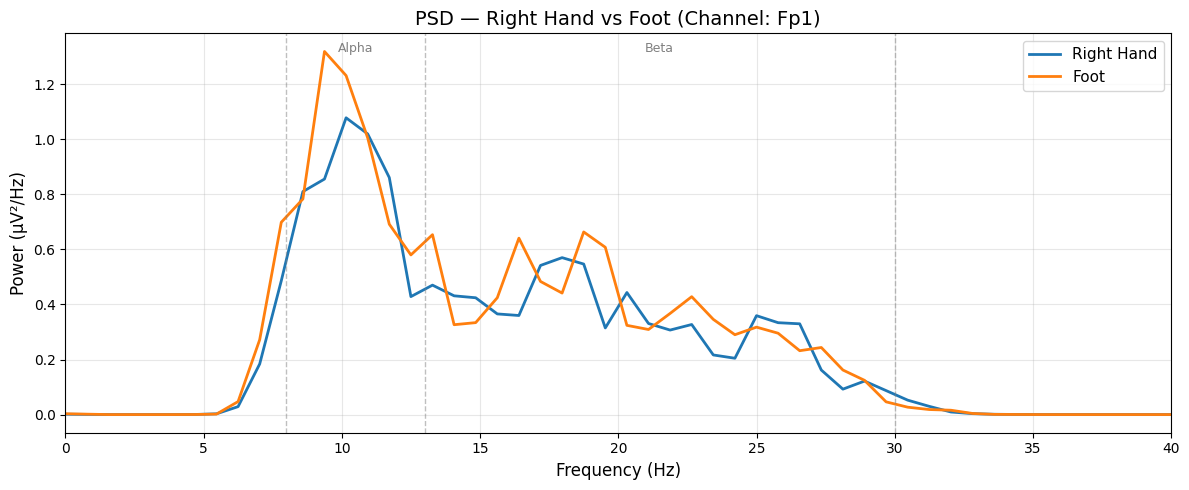

In [ ]:
print("="*60)
print("PSD ANALYSIS - RIGHT HAND VS FOOT")
print("="*60)

channel_name = 'Fp1'

try:
    channel_idx = clab.index(channel_name)
    print(f"Selected channel: {channel_name} (index: {channel_idx})")
except ValueError:
    print(f"ERROR: Channel '{channel_name}' not found!")
    print(f"Available motor channels: {[ch for ch in clab if 'C' in ch.upper()]}")
    raise

print(f"\nData shape: {X_labeled.shape}")
right_hand_epochs = X_labeled[y_labeled == 1]
foot_epochs       = X_labeled[y_labeled == 2]

print(f"Right hand epochs: {right_hand_epochs.shape}")
print(f"Foot epochs: {foot_epochs.shape}")

fs = 100

def compute_mean_psd(epochs, fs, channel):
    """Compute mean PSD across epochs for a single channel"""
    psds = []
    for ep in epochs:
        f, Pxx = welch(ep[:, channel], fs=fs, nperseg=128)
        psds.append(Pxx)
    return f, np.mean(psds, axis=0)

print(f"\nComputing PSD for channel {channel_name}...")
f, psd_right = compute_mean_psd(right_hand_epochs, fs, channel_idx)
_, psd_foot  = compute_mean_psd(foot_epochs, fs, channel_idx)


plt.figure(figsize=(12, 5))
plt.plot(f, psd_right, label="Right Hand", linewidth=2, )
plt.plot(f, psd_foot,  label="Foot", linewidth=2,)

plt.title(f"PSD — Right Hand vs Foot (Channel: {channel_name})",
          fontsize=14,)
plt.xlabel("Frequency (Hz)", fontsize=12)
plt.ylabel("Power (µV²/Hz)", fontsize=12)
plt.legend(fontsize=11, loc='upper right')
plt.grid(True, alpha=0.3)
plt.xlim(0, 40)

plt.axvline(x=8, color='gray', linestyle='--', alpha=0.5, linewidth=1)
plt.axvline(x=13, color='gray', linestyle='--', alpha=0.5, linewidth=1)
plt.axvline(x=30, color='gray', linestyle='--', alpha=0.5, linewidth=1)

plt.text(10.5, plt.ylim()[1]*0.95, 'Alpha', ha='center', fontsize=9, color='gray')
plt.text(21.5, plt.ylim()[1]*0.95, 'Beta', ha='center', fontsize=9, color='gray')

plt.tight_layout()


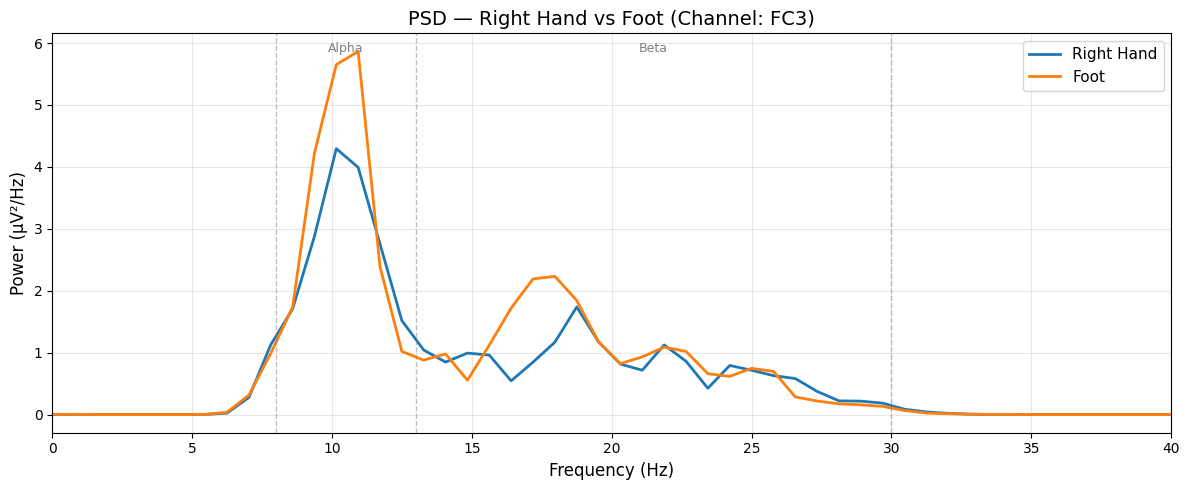

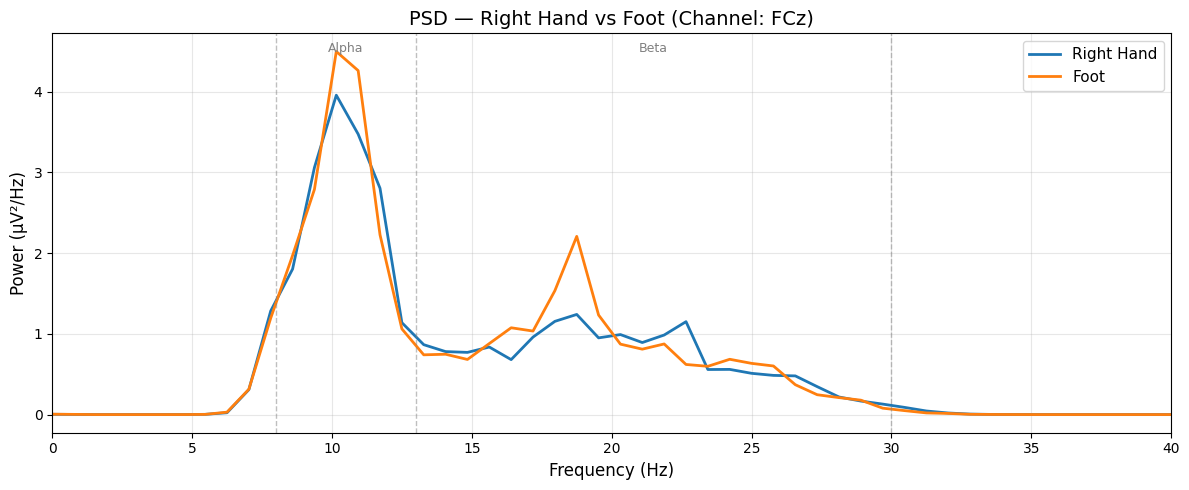

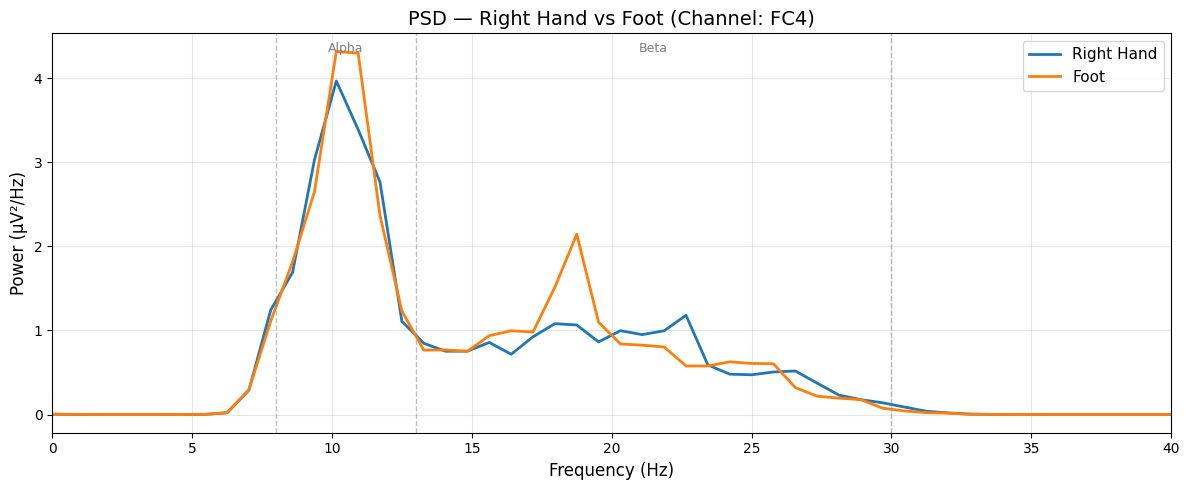

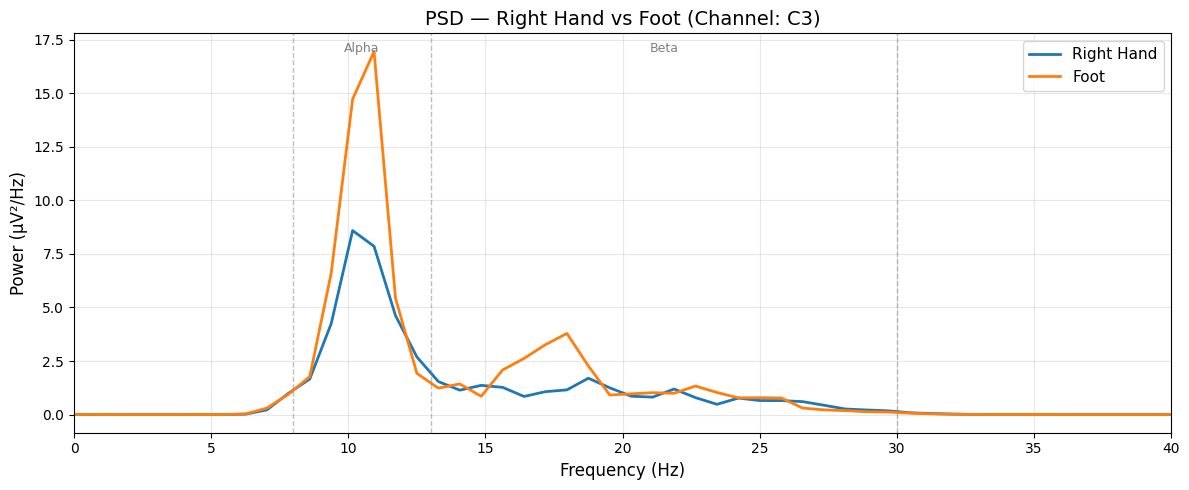

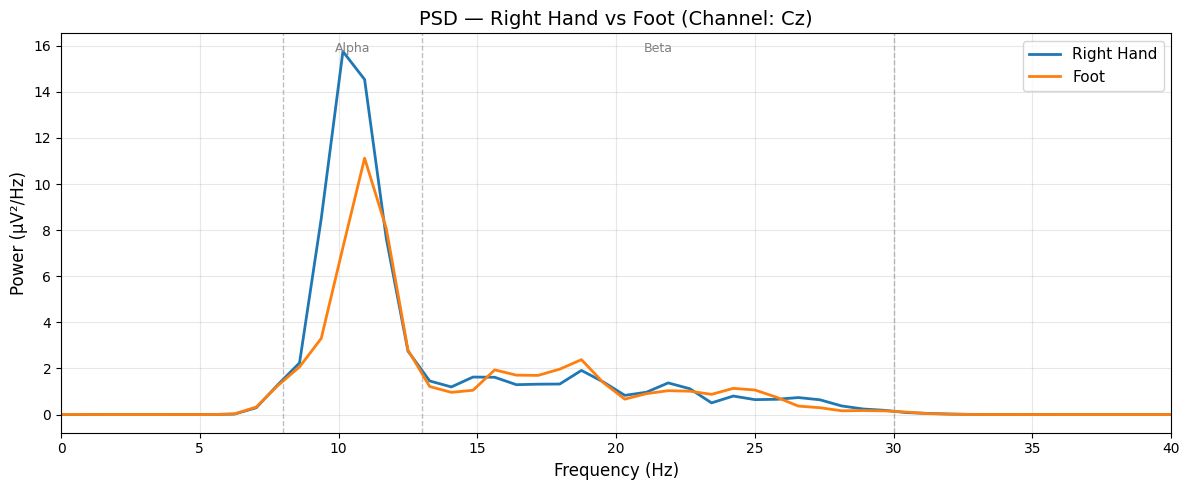

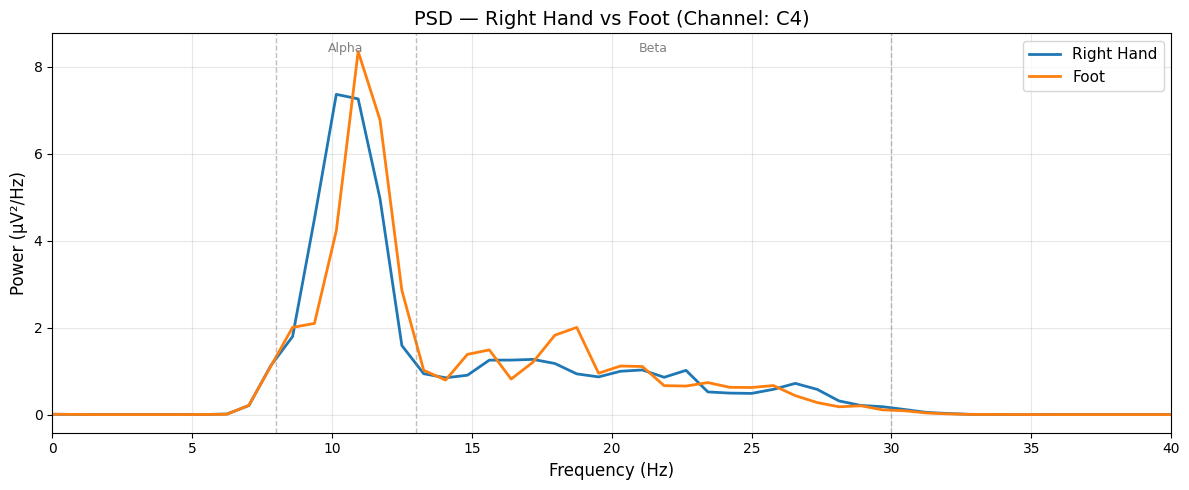

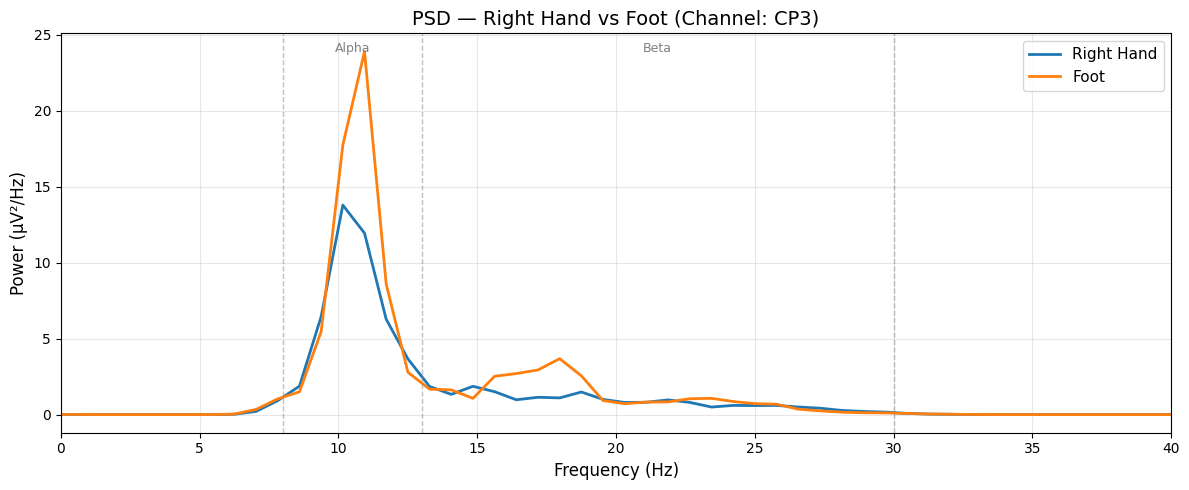

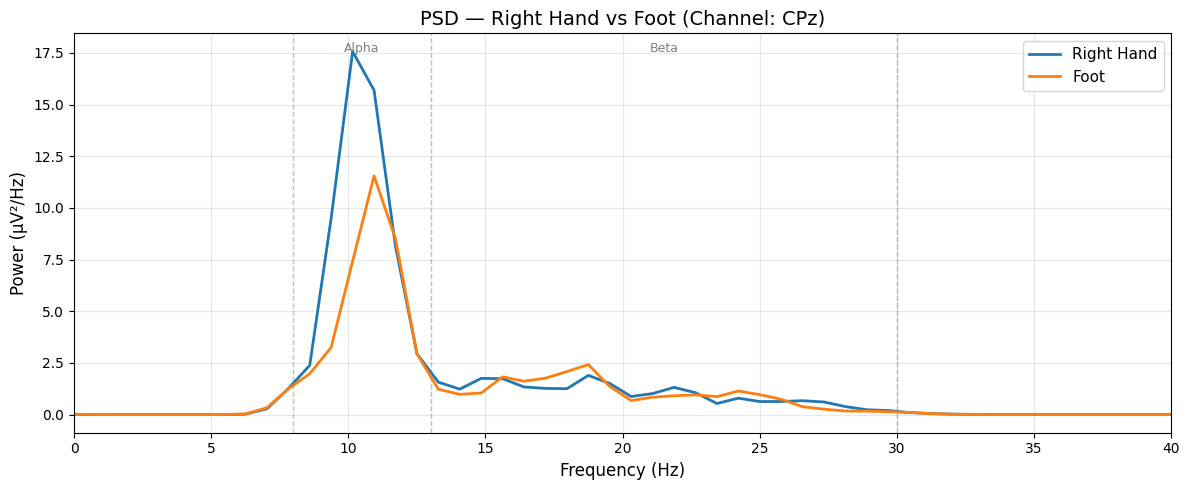

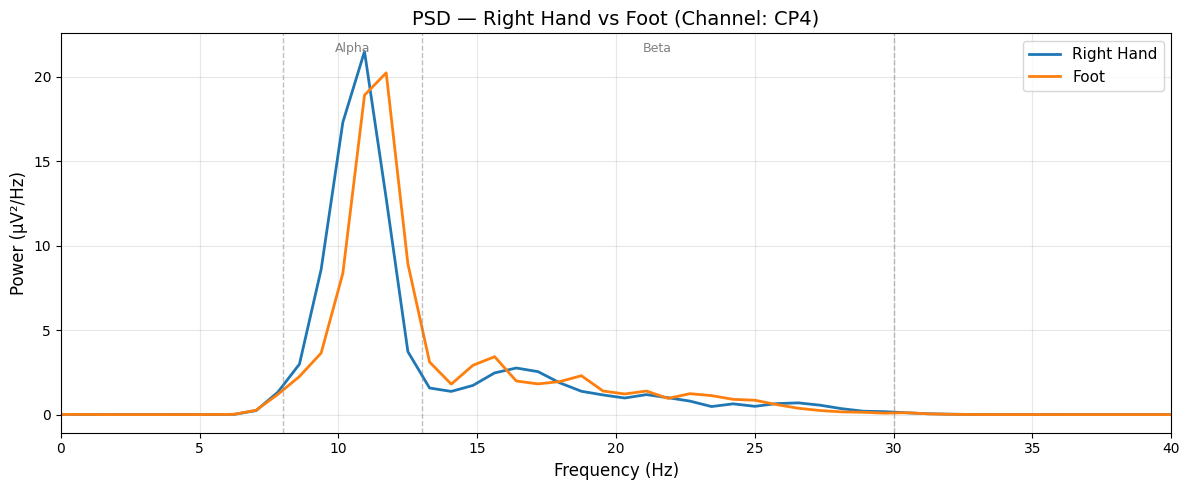

In [ ]:
target_names = ["C3", "C4", "Cz", "FC3", "FC4", "FCz", "CP3", "CP4", "CPz"]

target_names_lower = [t.lower() for t in target_names]


clab_lower = [label.lower() for label in clab]

motor_channel_indices = [
    i for i, label_lower in enumerate(clab_lower)
    if label_lower in target_names_lower
]


right_hand_epochs = X_labeled[y_labeled == 1]
foot_epochs       = X_labeled[y_labeled == 2]

fs = 100


def compute_mean_psd(epochs, fs, ch):
    """Compute mean PSD across epochs for a single channel"""
    psds = []
    for ep in epochs:
        f, Pxx = welch(ep[:, ch], fs=fs, nperseg=128)
        psds.append(Pxx)
    return f, np.mean(psds, axis=0)



for i, ch_global_index in enumerate(motor_channel_indices):
    ch_name = clab[ch_global_index]

    f, psd_right = compute_mean_psd(right_hand_epochs, fs, ch_global_index)
    _, psd_foot  = compute_mean_psd(foot_epochs, fs, ch_global_index)

    plt.figure(figsize=(12, 5))
    plt.plot(f, psd_right, label="Right Hand", linewidth=2, )
    plt.plot(f, psd_foot,  label="Foot", linewidth=2,)

    plt.title(f"PSD — Right Hand vs Foot (Channel: {ch_name})",
              fontsize=14,)
    plt.xlabel("Frequency (Hz)", fontsize=12)
    plt.ylabel("Power (µV²/Hz)", fontsize=12)
    plt.legend(fontsize=11, loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 40)

    plt.axvline(x=8, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    plt.axvline(x=13, color='gray', linestyle='--', alpha=0.5, linewidth=1)
    plt.axvline(x=30, color='gray', linestyle='--', alpha=0.5, linewidth=1)

    plt.text(10.5, plt.ylim()[1]*0.95, 'Alpha', ha='center', fontsize=9, color='gray')
    plt.text(21.5, plt.ylim()[1]*0.95, 'Beta', ha='center', fontsize=9, color='gray')

    plt.tight_layout()
    plt.show()

# Model Evaluation and Training

In [10]:
true_lables=loadmat('/content/true_labels_ay.mat')


In [11]:
actual=true_lables['true_y'].flatten()

In [12]:
y_test=actual[28:]

In [35]:
mne.set_log_level("ERROR")

def zscore_per_trial(X):
    mean = X.mean(axis=1, keepdims=True)
    std  = X.std(axis=1, keepdims=True)
    return (X - mean) / std


def reorder_for_csp(X):
    return np.transpose(X, (0, 2, 1))

X_labeled_norm   = zscore_per_trial(X_labeled)
X_unlabeled_norm = zscore_per_trial(X_unlabeled)

X_lab_csp   = reorder_for_csp(X_labeled_norm)
X_unlab_csp = reorder_for_csp(X_unlabeled_norm)

print("CSP Sweep Results:")
print("components | train_acc | test_acc")
print("-----------------------------------")

best_test_acc = 0
best_n_comp = None
best_csp = None
best_lda = None

for n_comp in range(1, 13):
    csp = CSP(n_components=n_comp, reg=None, log=True)
    lda = LDA()

    csp_features = csp.fit_transform(X_lab_csp, y_labeled)
    lda.fit(csp_features, y_labeled)

    train_pred = lda.predict(csp_features)
    train_acc = accuracy_score(y_labeled, train_pred)

    best_test_features = csp.transform(X_unlab_csp)
    y_pred = lda.predict(best_test_features)
    test_acc = accuracy_score(y_test, y_pred)

    print(f"{n_comp:10d} | {train_acc:.4f}   | {test_acc:.4f}")

    if test_acc > best_test_acc:
        best_test_acc = test_acc
        best_n_comp = n_comp
        best_csp = csp
        best_lda = lda

best_train_features = best_csp.transform(X_lab_csp)
train_pred = best_lda.predict(best_train_features)
best_train_acc = accuracy_score(y_labeled, train_pred)

best_test_features = best_csp.transform(X_unlab_csp)
y_pred = best_lda.predict(best_test_features)

print("\n" + "="*40)
print(f"Best Configuration:")
print(f"  Components: {best_n_comp}")
print(f"  Train Accuracy: {best_train_acc:.4f}")
print(f"  Test Accuracy: {best_test_acc:.4f}")
print("="*40)

CSP Sweep Results:
components | train_acc | test_acc
-----------------------------------
         1 | 0.9643   | 0.5635
         2 | 1.0000   | 0.6389
         3 | 1.0000   | 0.7817
         4 | 1.0000   | 0.7540
         5 | 1.0000   | 0.5317
         6 | 1.0000   | 0.5238
         7 | 1.0000   | 0.5357
         8 | 1.0000   | 0.5119
         9 | 1.0000   | 0.5040
        10 | 1.0000   | 0.5040
        11 | 1.0000   | 0.5040
        12 | 1.0000   | 0.5000

Best Configuration:
  Components: 3
  Train Accuracy: 1.0000
  Test Accuracy: 0.7817


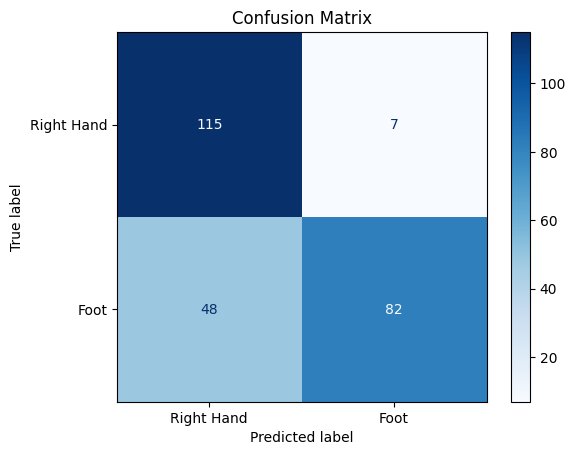

In [43]:
cm_test = confusion_matrix(y_test,y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_test,
                              display_labels=["Right Hand", "Foot"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.show()

In [37]:
print(classification_report(y_test, y_pred, target_names=["Right Hand", "Foot"]))


              precision    recall  f1-score   support

  Right Hand       0.71      0.94      0.81       122
        Foot       0.92      0.63      0.75       130

    accuracy                           0.78       252
   macro avg       0.81      0.79      0.78       252
weighted avg       0.82      0.78      0.78       252



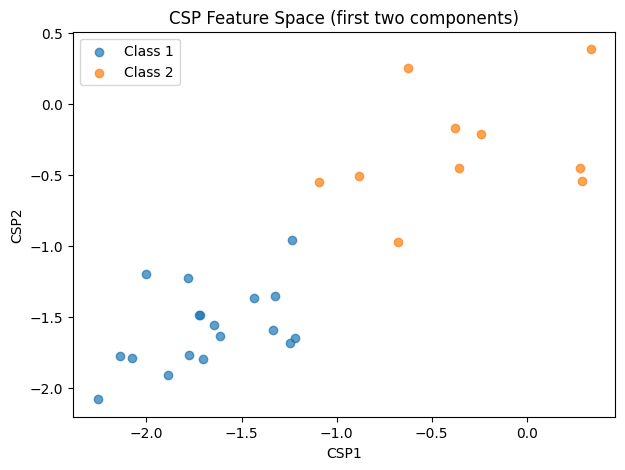

In [38]:
plt.figure(figsize=(7,5))
plt.scatter(best_train_features[y_labeled==1,0], best_train_features[y_labeled==1,1], label="Class 1", alpha=0.7)
plt.scatter(best_train_features[y_labeled==2,0], best_train_features[y_labeled==2,1], label="Class 2", alpha=0.7)
plt.title("CSP Feature Space (first two components)")
plt.xlabel("CSP1")
plt.ylabel("CSP2")
plt.legend()
plt.show()


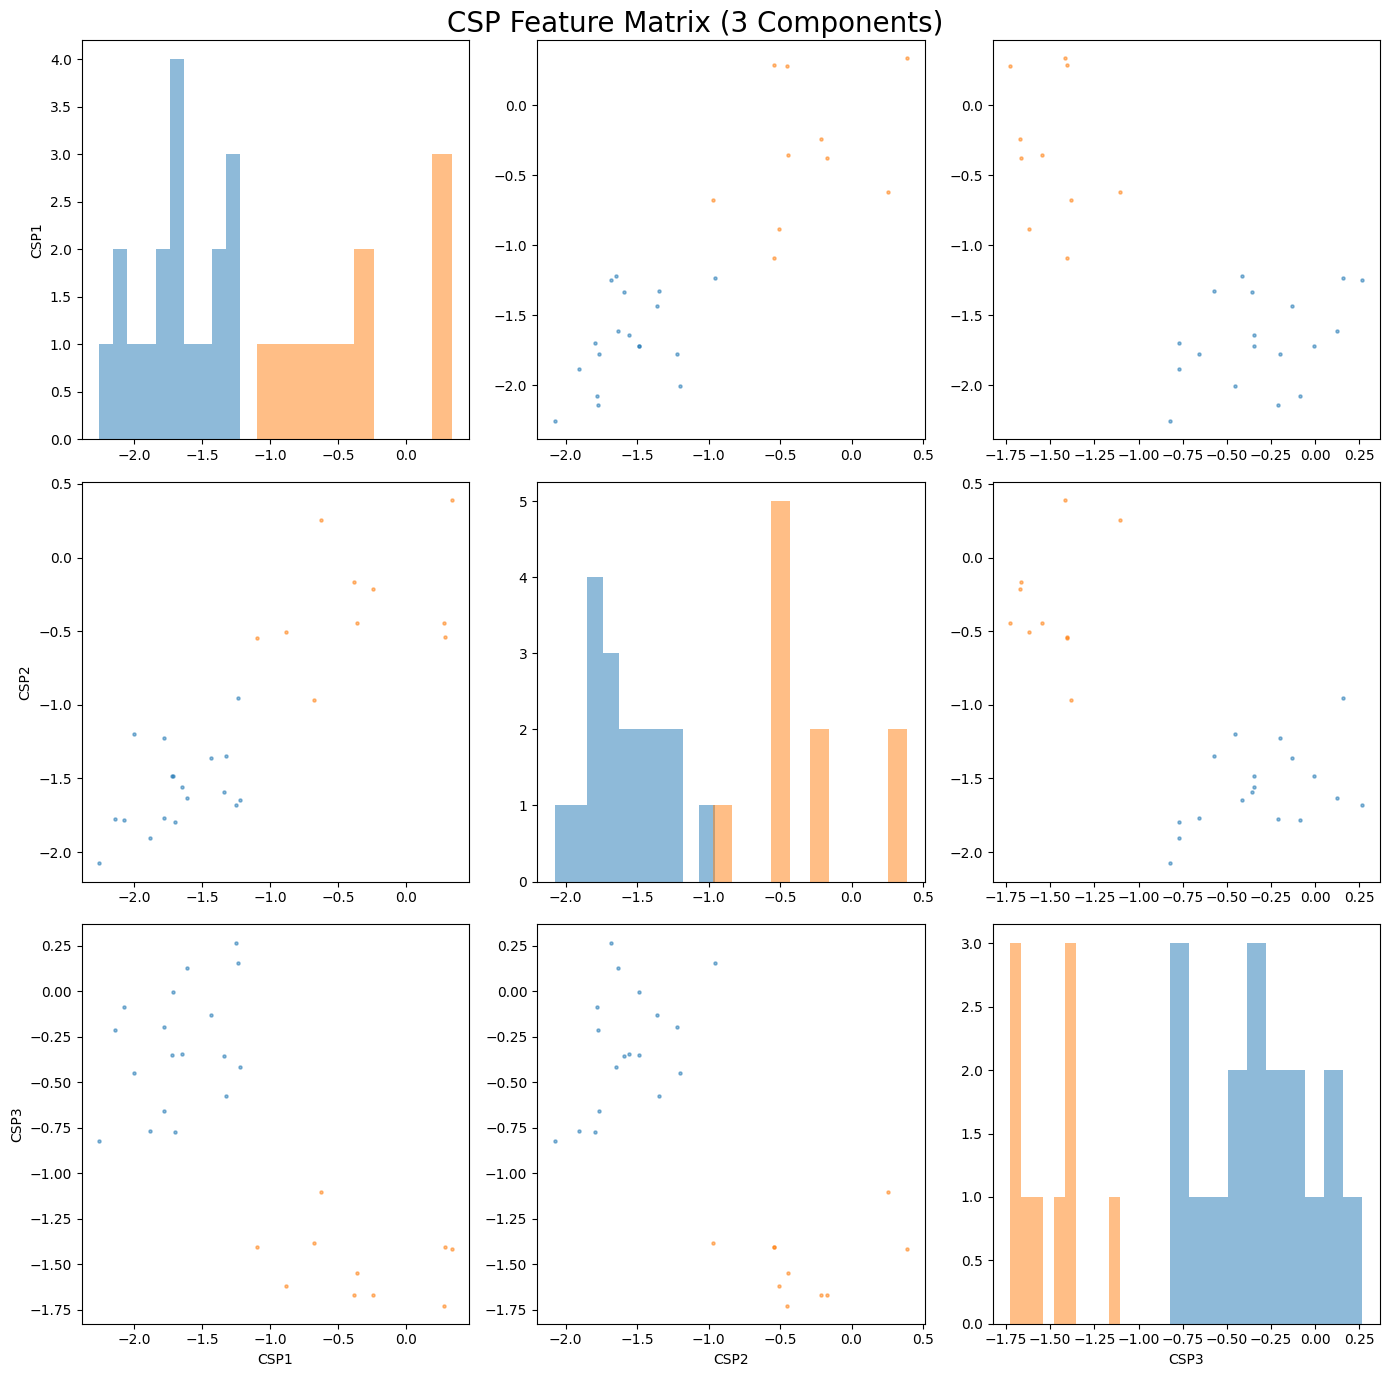

In [39]:
components = 3
fig, axes = plt.subplots(components, components, figsize=(14,14))

for i in range(components):
    for j in range(components):
        ax = axes[i,j]
        if i == j:
            ax.hist(best_train_features[y_labeled==1, i], alpha=0.5, label='Class 1')
            ax.hist(best_train_features[y_labeled==2, i], alpha=0.5, label='Class 2')
        else:
            ax.scatter(best_train_features[y_labeled==1, j],
                       best_train_features[y_labeled==1, i],
                       s=5, alpha=0.5)
            ax.scatter(best_train_features[y_labeled==2, j],
                       best_train_features[y_labeled==2, i],
                       s=5, alpha=0.5)
        if i == components - 1:
            ax.set_xlabel(f"CSP{j+1}")
        if j == 0:
            ax.set_ylabel(f"CSP{i+1}")

plt.suptitle("CSP Feature Matrix (3 Components)", fontsize=20)
plt.tight_layout()
plt.show()


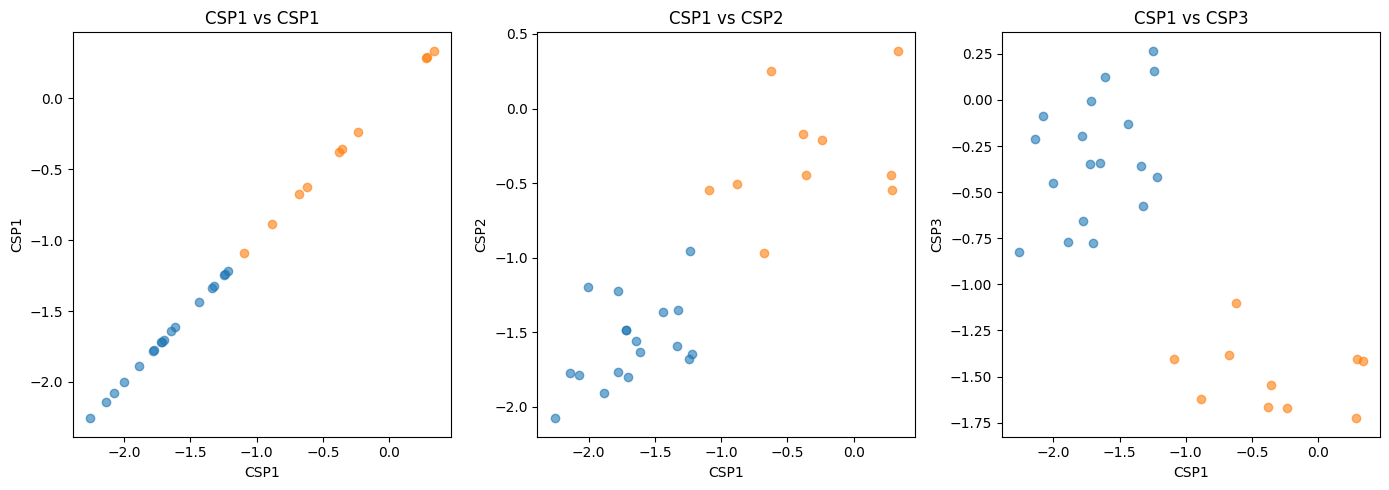

In [40]:
plt.figure(figsize=(14,5))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.scatter(best_train_features[y_labeled==1,0],
                best_train_features[y_labeled==1,i],
                alpha=0.6, label="Class 1")
    plt.scatter(best_train_features[y_labeled==2,0],
                best_train_features[y_labeled==2,i],
                alpha=0.6, label="Class 2")
    plt.xlabel("CSP1")
    plt.ylabel(f"CSP{i+1}")
    plt.title(f"CSP1 vs CSP{i+1}")

plt.tight_layout()
plt.show()


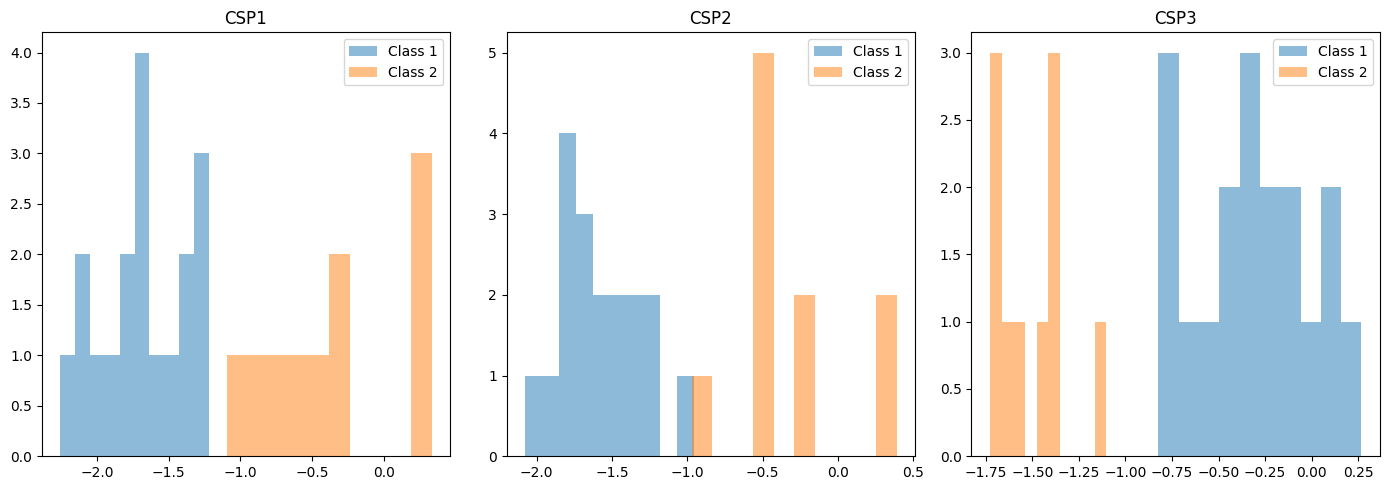

In [42]:
plt.figure(figsize=(14,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.hist(best_train_features[y_labeled==1, i], alpha=0.5, label='Class 1')
    plt.hist(best_train_features[y_labeled==2, i], alpha=0.5, label='Class 2')
    plt.title(f"CSP{i+1}")
    plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
model_filename = 'subject_ay_model'
joblib.dump(best_lda, model_filename)
